In [ ]:
a = []
while(1):
    a.append('1')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#1. Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [ ]:
base_skin_dir = os.path.join('..', '/content/drive/My Drive/Colab Notebooks/skin_cancer/base_skin')

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*.jpg'))}
# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# **Reading & Processing data**

In [ ]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'scenario1.csv'))

# Creating New Columns for better readability

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [ ]:
# Now lets see the sample of tile_df to look on newly made columns
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000000,ISIC_0028498,nv,histo,60.0,male,back,/content/drive/My Drive/Colab Notebooks/skin_c...,Melanocytic nevi,4
1,HAM_0000000,ISIC_0025346,nv,histo,60.0,male,back,/content/drive/My Drive/Colab Notebooks/skin_c...,Melanocytic nevi,4
2,HAM_0000001,ISIC_0027859,bkl,histo,70.0,female,face,/content/drive/My Drive/Colab Notebooks/skin_c...,Benign keratosis-like lesions,2
3,HAM_0000001,ISIC_0027859,bkl,histo,70.0,female,face,/content/drive/My Drive/Colab Notebooks/skin_c...,Benign keratosis-like lesions,2
4,HAM_0000001,ISIC_0027859,bkl,histo,70.0,female,face,/content/drive/My Drive/Colab Notebooks/skin_c...,Benign keratosis-like lesions,2


# **Data Cleaning**

In [ ]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              77
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [ ]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

In [ ]:
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [ ]:
print(skin_df.dtypes)

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object


# ***EDA***

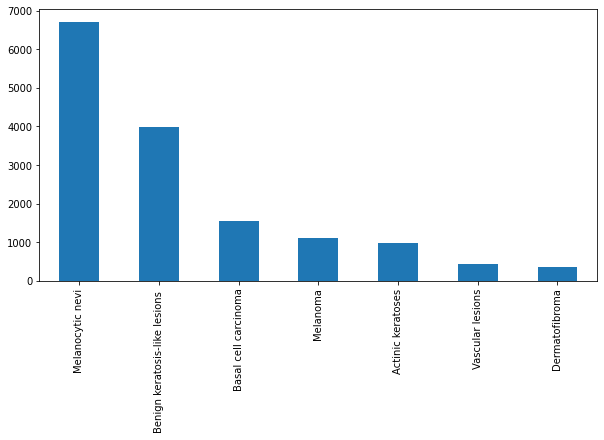

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

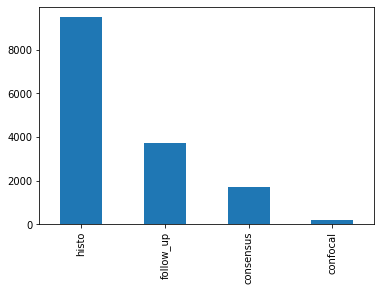

In [ ]:
skin_df['dx_type'].value_counts().plot(kind='bar')

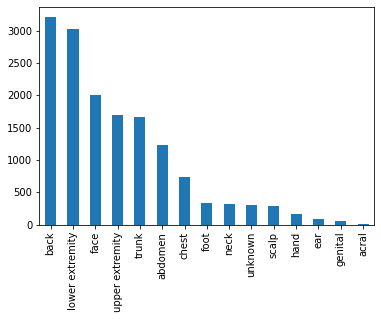

In [ ]:
skin_df['localization'].value_counts().plot(kind='bar')

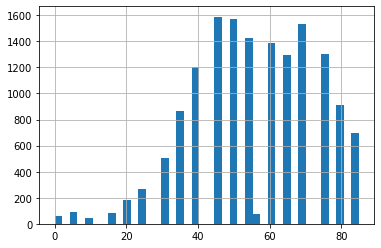

In [ ]:
skin_df['age'].hist(bins=40)

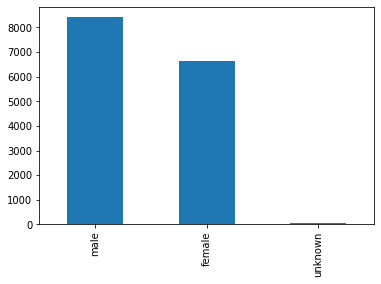

In [ ]:
skin_df['sex'].value_counts().plot(kind='bar')

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


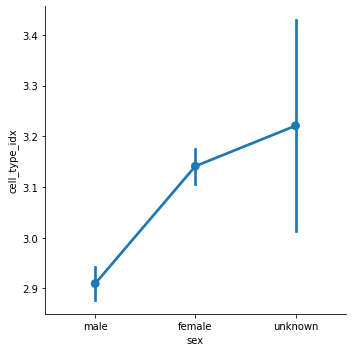

In [ ]:
sns.factorplot('sex','cell_type_idx',data=skin_df)

# **Loading & Resizing Images**

In [ ]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [ ]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000000,ISIC_0028498,nv,histo,60.0,male,back,/content/drive/My Drive/Colab Notebooks/skin_c...,Melanocytic nevi,4,"[[[138, 124, 124], [142, 125, 125], [140, 122,..."
1,HAM_0000000,ISIC_0025346,nv,histo,60.0,male,back,/content/drive/My Drive/Colab Notebooks/skin_c...,Melanocytic nevi,4,"[[[123, 108, 110], [131, 117, 119], [137, 125,..."
2,HAM_0000001,ISIC_0027859,bkl,histo,70.0,female,face,/content/drive/My Drive/Colab Notebooks/skin_c...,Benign keratosis-like lesions,2,"[[[186, 148, 148], [188, 153, 152], [190, 158,..."
3,HAM_0000001,ISIC_0027859,bkl,histo,70.0,female,face,/content/drive/My Drive/Colab Notebooks/skin_c...,Benign keratosis-like lesions,2,"[[[186, 148, 148], [188, 153, 152], [190, 158,..."
4,HAM_0000001,ISIC_0027859,bkl,histo,70.0,female,face,/content/drive/My Drive/Colab Notebooks/skin_c...,Benign keratosis-like lesions,2,"[[[186, 148, 148], [188, 153, 152], [190, 158,..."


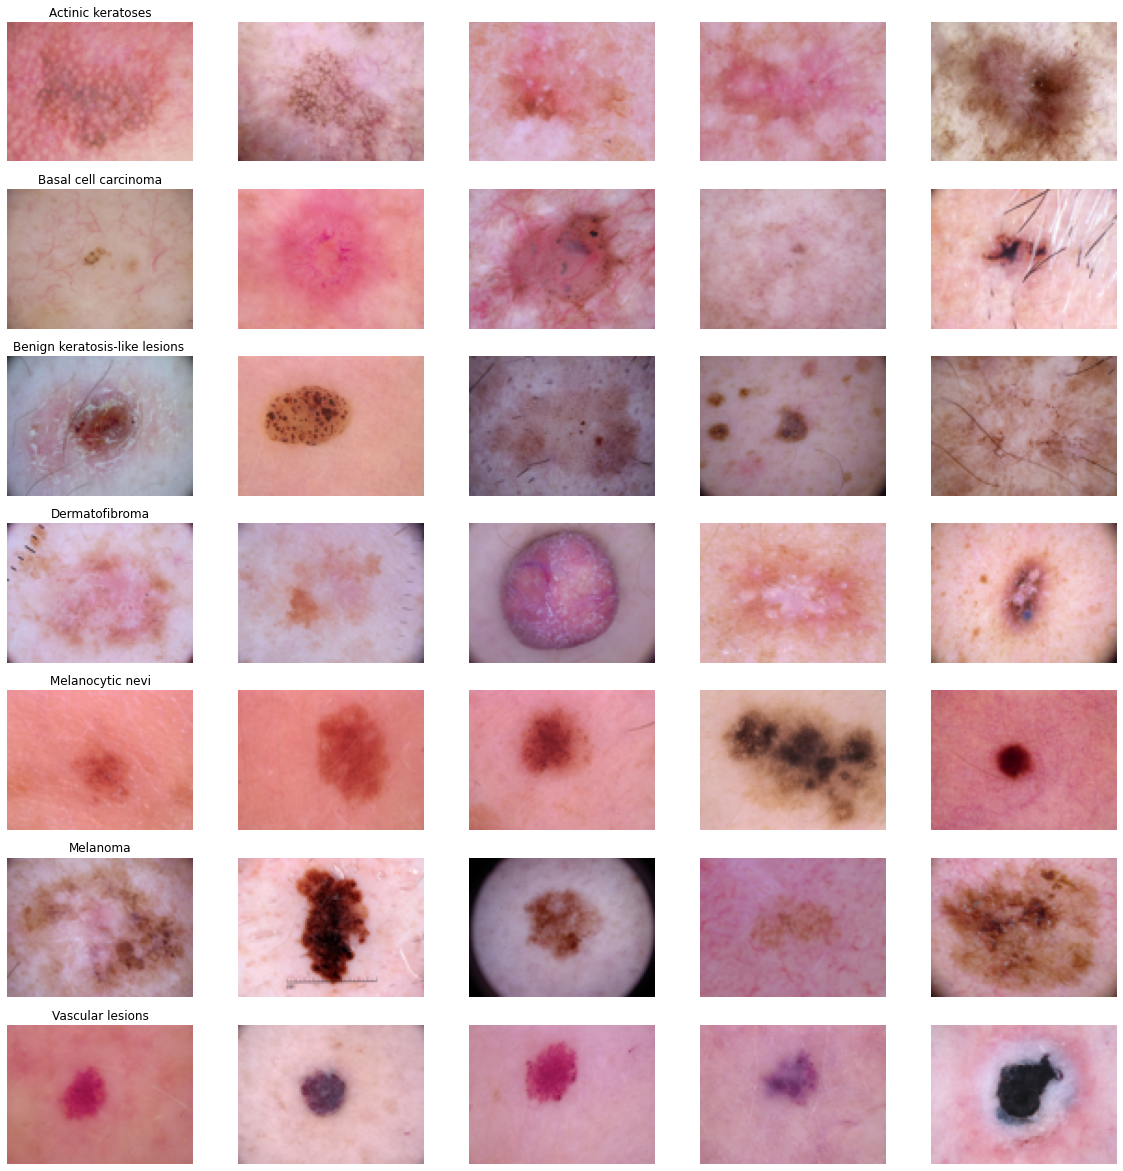

In [ ]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [ ]:
# Checking the image size distribution
skin_df['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    15103
Name: image, dtype: int64

In [ ]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

# **Train Test & Split**

In [ ]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)

# **Normalization**

In [ ]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

# **Label Encoding**

In [ ]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

# **Split Train & Validation**

In [ ]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.2, random_state = 2018)

In [ ]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [ ]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(BatchNormalization())
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Conv2D(128, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.50))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 75, 100, 32)       896       
_________________________________________________________________
batch_normalization_23 (Batc (None, 75, 100, 32)       128       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 75, 100, 32)       9248      
_________________________________________________________________
batch_normalization_24 (Batc (None, 75, 100, 32)       128       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 37, 50, 32)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 37, 50, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 37, 50, 64)       

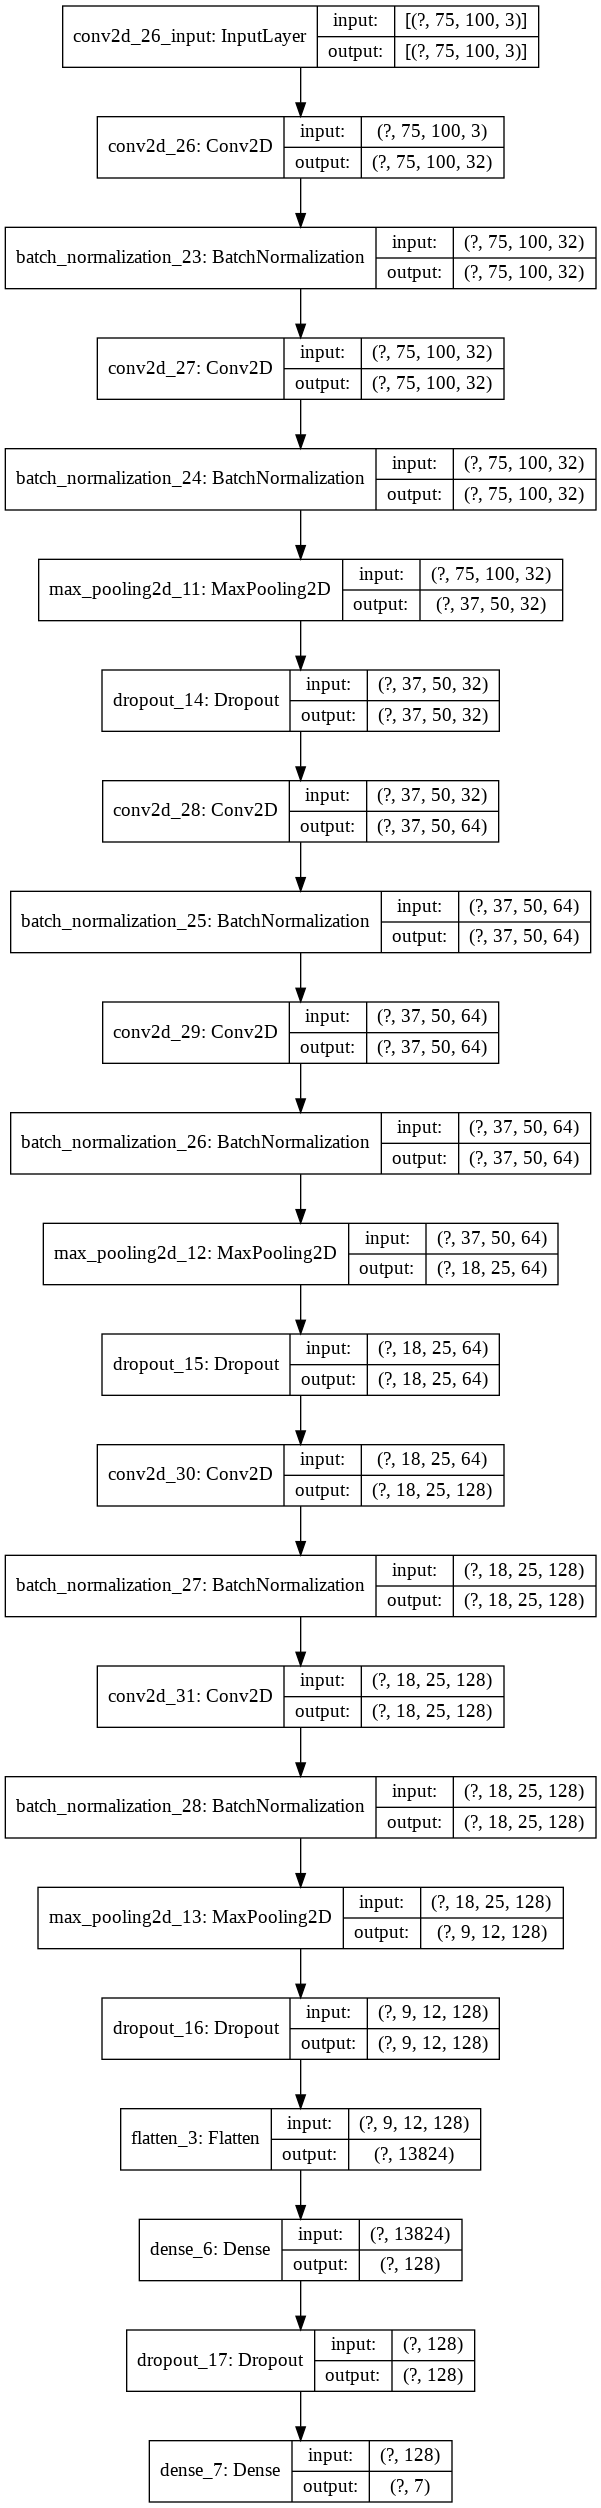

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.001, amsgrad=False)

In [ ]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.001)

In [ ]:
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [ ]:
# Fit the model
epochs = 100 
batch_size = 48
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/100
201/201 [==============================] - 16s 82ms/step - loss: 1.6508 - accuracy: 0.4883 - val_loss: 1.3682 - val_accuracy: 0.5362
Epoch 2/100
201/201 [==============================] - 17s 83ms/step - loss: 1.3258 - accuracy: 0.5181 - val_loss: 1.2982 - val_accuracy: 0.5676
Epoch 3/100
201/201 [==============================] - 16s 82ms/step - loss: 1.2455 - accuracy: 0.5396 - val_loss: 1.1302 - val_accuracy: 0.5925
Epoch 4/100
201/201 [==============================] - 16s 81ms/step - loss: 1.1635 - accuracy: 0.5638 - val_loss: 1.1163 - val_accuracy: 0.5863
Epoch 5/100
201/201 [==============================] - 16s 82ms/step - loss: 1.1535 - accuracy: 0.5777 - val_loss: 1.0502 - val_accuracy: 0.5966
Epoch 6/100
201/201 [==============================] - 16s 81ms/step - loss: 1.1110 - accuracy: 0.5877 - val_loss: 0.9470 - val_accuracy: 0.6512
Epoch 7/100
201/201 [==============================] - 16s 81ms/step - loss: 1.0773 - accuracy: 0.5974 - val_loss: 0.8857 - val_ac

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model.h5")

76/76 [==============================] - 0s 6ms/step - loss: 0.4850 - accuracy: 0.8308
Validation: accuracy = 0.830782  ;  loss_v = 0.485028
Test: accuracy = 0.825885  ;  loss = 0.482711


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


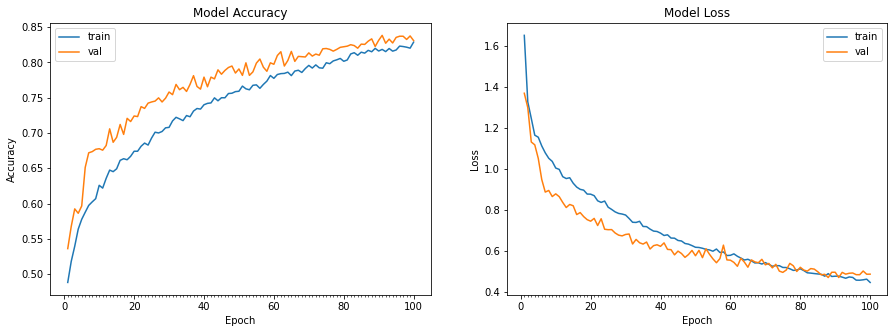

In [ ]:
plot_model_history(history)

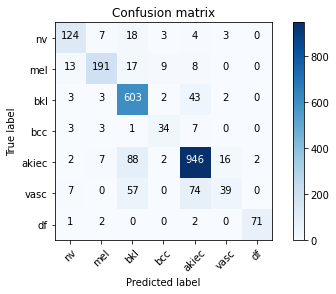

In [ ]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
#class_names = ['nv', 'mel','bkc','bcc','akiec','vasc','df']
# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)


# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = lesion_type_dict) 
#plt.xticks(range(7), ['nv', 'mel','bkc','bcc','akiec','vasc','df'], fontsize=8)
#plt.yticks(range(7), ['nv', 'mel','bkc','bcc','akiec','vasc','df'], fontsize=8)

# **Classification Report**

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(Y_true, Y_pred_classes ,target_names=lesion_type_dict))

              precision    recall  f1-score   support

          nv       0.81      0.78      0.79       159
         mel       0.90      0.80      0.85       238
         bkl       0.77      0.92      0.84       656
         bcc       0.68      0.71      0.69        48
       akiec       0.87      0.89      0.88      1063
        vasc       0.65      0.22      0.33       177
          df       0.97      0.93      0.95        76

    accuracy                           0.83      2417
   macro avg       0.81      0.75      0.76      2417
weighted avg       0.83      0.83      0.82      2417

